# 시계열 분석

## By OPTIMUM
***
고객님 요청하신 시계열 분석과 관련된 코드입니다. 최대한 수학과 관련된 부분은 배제한채 실무에 바로 적용하실 수 있도록 준비해 보았습니다.

혹시라도 궁금하신점이 있다면 언제든지 문의주세요~!

***
## 시계열 자료의 종류
- 비정상성 시계열 자료 : 대부분의 시계열 자료에 해당. 별도의 전처리 필요.
- 정상성 시계열 자료 : 비정상 시계열을 전처리하여 다루기 쉬운 시계열 자료로 변환한 것.

### 정상시계열의 특징
- 평균이 일정하다 : 모든 시점에 대해 일정한 평균을 가진다. 평균이 일정하지 않은 시계열은 차분(difference)을 통해 정상화 한다.
- 분산이 일정하다 : 평균과 마찬가지로 시점에 의존하지 않고 분산이 일정하다. 분산이 일정하지 않은 경우 변환(transformation)을 통해 정상화 한다.
- 공분산도 단지 시차에만 의존한다.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("rawdata.txt", sep = '\t')

In [3]:
data.head()

,Date,System1_Try,System1_Succ,System2_Try,System2_Succ
0,2021-06-06 23:55,2104,63.83,1172,67.49
1,2021-06-06 23:50,2129,65.76,1268,67.59
2,2021-06-06 23:45,2184,63.14,1332,68.47
3,2021-06-06 23:40,2326,64.19,1298,65.79
4,2021-06-06 23:35,2554,65.11,1389,68.68


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          2016 non-null   object 
 1   System1_Try   2016 non-null   int64  
 2   System1_Succ  2016 non-null   float64
 3   System2_Try   2016 non-null   int64  
 4   System2_Succ  2016 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 78.9+ KB


In [5]:
data['Date'] = pd.to_datetime(data['Date'])

Date 컬럼을 시계열 타입으로 변환합니다.

In [6]:
data.set_index('Date', inplace = True)

인덱스로 지정하기 위해 set_index 메서드를 사용합니다.

In [7]:
data.sort_index(inplace = True)

In [8]:
data.head()

,System1_Try,System1_Succ,System2_Try,System2_Succ
Date,,,,
2021-05-31 00:00:00,1922,65.56,1133,69.11
2021-05-31 00:05:00,2108,65.04,1111,65.89
2021-05-31 00:10:00,2076,64.79,1042,67.47
2021-05-31 00:15:00,1956,64.78,1005,65.47
2021-05-31 00:20:00,1767,64.80,976,70.29


data의 index를 확인해 보니 freq = None으로 설정되어 있는 것을 알 수 있습니다. 시계열 분석을 위해서는 저 freq인자를 별도로 지정을 해주어야 합니다.

고객님께서 확인하시고 싶은 시간 간격을 지정해주면 됩니다.

크게 두 가지 버전의 데이터를 구축해보겠습니다.

1. 5분 간격의 데이터
2. 1시간 간격의 데이터


#### 1. 5분 간격의 데이터

In [9]:
data1 = data.asfreq(freq = '5T')

In [10]:
data1.index

DatetimeIndex(['2021-05-31 00:00:00', '2021-05-31 00:05:00',
               '2021-05-31 00:10:00', '2021-05-31 00:15:00',
               '2021-05-31 00:20:00', '2021-05-31 00:25:00',
               '2021-05-31 00:30:00', '2021-05-31 00:35:00',
               '2021-05-31 00:40:00', '2021-05-31 00:45:00',
               ...
               '2021-06-06 23:10:00', '2021-06-06 23:15:00',
               '2021-06-06 23:20:00', '2021-06-06 23:25:00',
               '2021-06-06 23:30:00', '2021-06-06 23:35:00',
               '2021-06-06 23:40:00', '2021-06-06 23:45:00',
               '2021-06-06 23:50:00', '2021-06-06 23:55:00'],
              dtype='datetime64[ns]', name='Date', length=2016, freq='5T')

index의 freq가 5분 간격으로 설정된 것을 알 수 있습니다.

이제 본격적인 분석에 들어가 보겠습니다.

시계열 분석에서 가장 기본적으로 확인해야 할 것은 데이터의 정상성(stationary) 여부 입니다.

해당 변수가 정상성을 만족해야 분석을 진행할 수 있습니다.



머신러닝의 기본 전제 조건은 예측을 하고자 하는 데이터에 대한 정보는 학습에 사용할 수 없습니다. 이를 미래참조(Data Leakage) 문제라고 하는데 가령 내일 기온을 예측하는데 내일의 강수량 변수를 사용하는 논리입니다. 어불성설이죠 내일은 아직 오지 않았으니까. 하지만 많은 사람들이 이런 문제를 잊은채 모델링을 하곤 합니다. 따라서 정상성 여부는 물론 모델 학습까지 학습데이터만 사용해야 합니다. 우선 데이터를 특정 시점 기준으로 train & test로 분할하겠습니다.

과거 1800개의 데이터로 향후 216개의 데이터를 예측해보겠습니다.

In [11]:
y_train = data1.System1_Try.iloc[:1800]
y_test = data1.System1_Try.iloc[1800:]

그렇다면 정상성 여부를 한 번 확인해 보겠습니다.

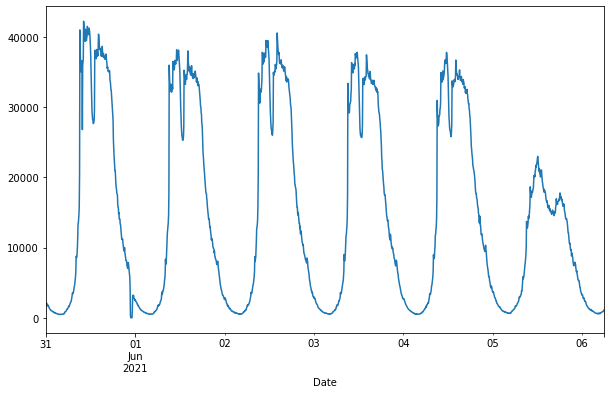

In [12]:
plt.figure(figsize = (10, 6))
y_train.plot()
plt.show()

엄청난 주기성, 트랜드를 나타내고 있는 것을 확인할 수 있습니다. 그리고 큰 주기는 1일 작은 주기는 또 시간대별로 있을 것으로 예상됩니다.

시계열 데이터의 정상성을 확인하는 방법은 크게 3가지가 있습니다.

1. ACF & PACF Plot : 두 그래프를 그려 정상화 여부를 판단합니다.

|확률과정| ACF | PACF |
|---|---|---|
|AR(p) | 지수적으로 감소하거나 소멸하는 싸인함수 형태 | 시차 p이후에는 0으로의 절단형태|
|MA(q)| 시차 q이후에는 0으로의 절단형태 | 지수적으로 감소하거나 소멸하는 싸인함수 형태|
|ARMA(p, q) | 시차(q-p) 이후에는 지수적으로 감소하거나 소멸하는 싸인함수 형태 | 시차(p-q) 이후에는 지수적으로 감소하거나 소멸하는 싸인함수 형태|


2. KPSS 검정 : 통계적 검정 방법 중 하나로 통계량과 유의확률을 계산하여 시계열 자료의 정상성 여부를 판단합니다.
3. ADF 검정 : KPSS와 마찬가지로 통계량과 유의확률을 계산하여 시계열 자료의 정상성 여부를 판단합니다.

먼저, ACF & PACF를 사용해보겠습니다.

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

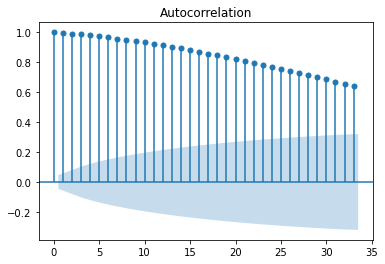

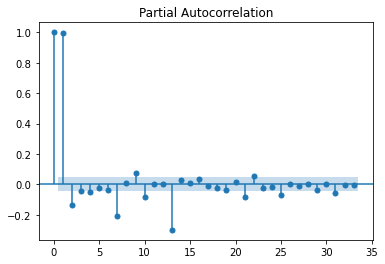

In [14]:
plot_acf(y_train)
plot_pacf(y_train)
plt.show()

위의 그림을 살펴보면 ACF의 경우 천천히 감소하지만 PACF의 경우 빠르게 감소하며 5일 때 파란 박스 안에 점이 찍히는 것을 알 수 있습니다. 따라서 p=4라는 결론을 도출할 수 있습니다. 하지만 해당 방법의 경우 사용자가 직관적으로 눈으로 확인해야 하기 때문에 경험에 의존하여 신뢰할 만한 결과를 항상 가져다주지는 못합니다.

그렇기 때문에 위에 언급드린 통계적 검정 방법들을 사용하곤 합니다.

우선 KPSS부터 살펴보겠습니다.

In [15]:
from statsmodels.tsa.stattools import kpss

KPSS(Kwiatkowski-Phillips-Schmidt-Shin) 테스트는 시계열이 평균 또는 선형 추세의 주변에 고정되어 있는지에 대해 확인합니다.

- $H_{0}$ : 시계열이 안정적이다.
- $H_{1}$ : 시계열이 안정적이지 않다.

In [16]:
def get_kpss(x) :
    
    statistic, p_value, _, _ = kpss(x)

    print(f"KPSS Statistic : {statistic}")
    print(f"P-value : {p_value}\n")
    
    diff_statistic, diff_p_value, _, _ = kpss(x.diff().dropna())
    
    print(f"After Difference, KPSS Statistic : {statistic}")
    print(f"After Difference, P-value : {p_value}\n")
    
    if (p_value > diff_p_value) & (diff_p_value < 0.05) :
        print("차분이 필요합니다.")
    else :
        print("차분이 필요하지 않습니다.")

In [17]:
get_kpss(y_train)

KPSS Statistic : 0.20058773555563228
P-value : 0.1

After Difference, KPSS Statistic : 0.20058773555563228
After Difference, P-value : 0.1

차분이 필요하지 않습니다.


/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


KPSS검정 결과 귀무가설을 기각하지 못하고 귀무가설을 채택하므로 차분을 통한 정상화가 필요하지 않다는 결론을 도출하였습니다.

다음은 ADF(Augmented Dickey-Fuller) 검정입니다. 해당 검정 또한 시계열의 정상성 여부를 판단합니다.

- $H_{0}$ : 시계열이 안정적이지 않다.
- $H_{1}$ : 시계열이 안정적이다.

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
def get_kpss(x) :
    
    statistic, p_value, _, _, _, _ = adfuller(x)

    print(f"ADF Statistic : {statistic}")
    print(f"P-value : {p_value}")
    if p_value < 0.05 :
        print("정상성을 만족합니다.\n")
    else :
        print("정상성을 만족하지 않습니다.\n")
    
    diff_statistic, diff_p_value, _, _, _, _ = adfuller(x.diff().dropna())
    
    print(f"After Difference, ADF Statistic : {statistic}")
    print(f"After Difference, P-value : {p_value}")
    if diff_p_value < 0.05 :
        print("정상성을 만족합니다.")
    else :
        print("정상성을 만족하지 않습니다.")

In [20]:
get_kpss(y_train)

ADF Statistic : -4.116038855872162
P-value : 0.0009110617548198779
정상성을 만족합니다.

After Difference, ADF Statistic : -4.116038855872162
After Difference, P-value : 0.0009110617548198779
정상성을 만족합니다.


ADF 검정 결과 차분 여부와 상관 없이 데이터는 정상성을 만족한다는 결론을 도출하였습니다.

그렇다면 궁금증이 생길수도 있습니다.

과연 두개의 통계적 검정 방법이 서로 다른 결과를 보일 때는 어떻게 해야할까요?

1. KPSS = stationary but ADF = not stationary인 경우 trend를 제거해 주어야 합니다.

2. KPSS = not stationary but ADF = stationary인 경우는 차분이 필요한 경우입니다.

데이터의 정상성 여부를 확인하였으니 실제로 모델링에 들어가보도록 하겠습니다. 그전에 간단히 이동평균선을 그려 데이터의 추세를 살펴보겠습니다.

In [21]:
def plot_rolling(data, interval):
    
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label = '원래 값')
    mean = plt.plot(rolmean, color='red', label = f'{interval} 단위 이동 평균')
    std = plt.plot(rolstd, color='black', label = '이동 평균 값의 편차')
    plt.legend(loc='best')
    plt.show()

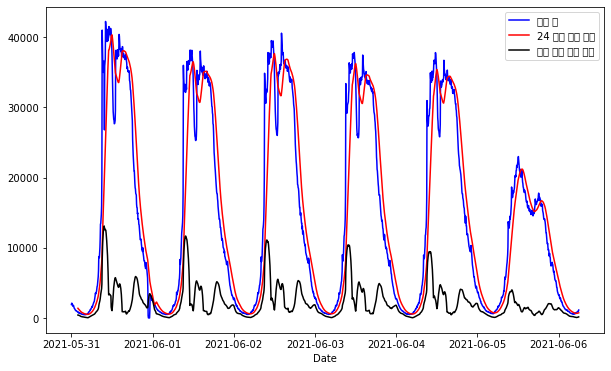

In [22]:
plot_rolling(y_train, 24)

간단히 24시점 뒤 즉, 24시점 * 5분인 2시간 이동 평균선을 그렸을 때 기존 값과 상당히 유사한 형태로 그려지는 것을 알 수 있습니다.

먼저 간단한 ARIMA 모형을 사용해보도록 하겠습니다.

### 자기회귀누적이동평균모형(ARIMA(p, d, q) 모형 / AutoRegressive Integrated Moving Average Model)
- ARMIA 모형은 비정상시계열 모형이다.
- 차분이나 변환을 통해 AR모형, MA모형, 이 둘을 합친 ARMA 모형으로 정상화 할 수 있다.
- p는 AR 모형, q는 MA 모형과 관련이 있는 차수이다.
- 시계열 {$Z_{t}$}의 d번 차분한 시계열이 ARMA(p, q)모형이면 시계열{$Z_{t}$}는 차수가 p, d, q인 ARIMA모형, 즉 ARIMA(p,d,q) 모형을 갖는다고 한다.
- d = 0인 경우 ARMA(p,q)모형이라 부르고 이 모형은 정상성을 만족한다.
- p = 0인 경우 IMA(d,q)모형이라 부르고 d번 차분하면 MA(q) 모형을 따른다.
- q = 0인 경우 ARI(p,d)모형이라 부르고 d번 차분하면 AR(p) 모형을 따른다.
- acf,pacf를 통해 정상성을 확인할 수도 있지만, adf검정을 통해 확인할 수 있다.(통계적 방법)
#### 예시
- ARIMA(0,1,1)인 경우 1차분 후 MA(1) 활용
- ARIMA(1,1,0)인 경우 1차분 후 AR(1) 활용
- ARIMA(1,1,2)인 경우 1차분 후 AR(1), MA(2), ARMA(1,2) 중 선택 활용 : 이 경우 가장 간단한 모형을 선택하거나 AIC를 적용하여 점수가 가장 낮은 모형을 선정한다.

***
#### AR(p) = ARIMA(p, 0, 0)
#### MA(q) = ARIMA(0, 0, q)
#### ARMA(p, q) = ARIMA(p, 0, q)

***
#### ARIMA의 모수는 크게 3가지가 있다. AR모형의 Lag를 의미하는 p, MA모형의 Lag를 의미하는 q, 차분 횟수를 의미하는 d가 그것이다. 
- 통상적으로 p + q < 2, p * q = 0 인 값들을 많이 사용한다.

In [23]:
from statsmodels.tsa.arima_model import ARIMA

위에서 확인한 ARIMA의 파라미터(p, d, q)를 자동으로 탐색해주는 커스텀 함수입니다. 벌점화 선택기준인 AIC를 기준으로 가장 낮은 AIC를 가지는 파라미터 조합을 탐색합니다.

In [24]:
def my_auto_arima(data, order, sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order = (p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)), columns = ['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [25]:
auto_df = my_auto_arima(y_train, [3,2,3])
auto_df.sort_values(by = 'AIC').head(1)

,order,AIC
13,p2 d0 q2,30508.329008


parameter 조합이 p = 2, d = 0, q = 2인 것으로 나타났습니다. d = 0인 이유는 위에서 살펴보았듯이 차분이 필요하지 않기 때문에 차분 파라미터를 의미하는 d는 0입니다.

In [26]:
order = (2, 0, 2)
model = ARIMA(y_train, order)
arima = model.fit()
arima.summary() # AIC가 작을수록 좋음

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            System1_Try   No. Observations:                 1800
Model:                     ARMA(2, 2)   Log Likelihood              -15248.165
Method:                       css-mle   S.D. of innovations           1153.544
Date:                Sat, 12 Jun 2021   AIC                          30508.329
Time:                        09:06:52   BIC                          30541.302
Sample:                    05-31-2021   HQIC                         30520.501
                         - 06-06-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.487e+04    847.588     17.548      0.000    1.32e+04    1.65e+04
ar.L1.System1_Try     1.9942      0.002    808.844      0.000       1.989       1.999
ar.L2.System1_Try    -0.9946      0.002   -404.431      0.000      -0.999      -0.990
ma.L1.System1_Try    -0.9100      0.024    -38.428      0.000      -0.956      -0.864
ma.L2.System1_Try    -0.0778      0.024     -3.304      0.001      -0.124      -0.032
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0025           -0.0213j            1.0027           -0.0034
AR.2            1.0025           +0.0213j            1.0027            0.0034
MA.1            1.0115           +0.0000j            1.0115            0.0000
MA.2          -12.7125           +0.0000j           12.7125            0.5000
-----------------------------------------------------------------------------
"""

실제 모델로 데이터를 학습합니다.

In [27]:
pred = arima.predict(start = y_test.index[0], end = y_test.index[-1], typ = 'levels')

학습한 모델을 사용하여 test 값을 예측합니다.

In [28]:
pred.head()

2021-06-06 06:00:00    1460.788162
2021-06-06 06:05:00    1808.192923
2021-06-06 06:10:00    2159.737703
2021-06-06 06:15:00    2515.238825
2021-06-06 06:20:00    2874.511777
Freq: 5T, dtype: float64

In [29]:
y_test.head()

Date
2021-06-06 06:00:00    1247
2021-06-06 06:05:00    1297
2021-06-06 06:10:00    1314
2021-06-06 06:15:00    1393
2021-06-06 06:20:00    1426
Freq: 5T, Name: System1_Try, dtype: int64

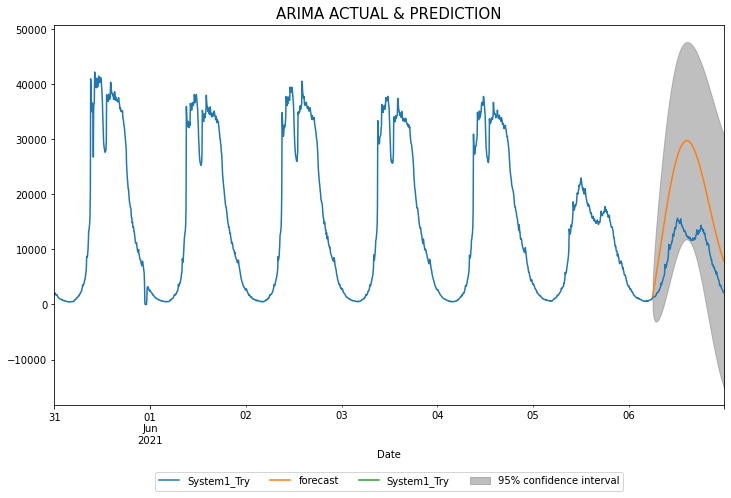

In [30]:
plt.figure(figsize = (12, 7))
ax = data.System1_Try.plot()
plt.title('ARIMA ACTUAL & PREDICTION', size = 15)
arima.plot_predict(start = y_test.index[0], end = y_test.index[-1], ax = ax)
plt.legend(loc = 'center', bbox_to_anchor = (.5, -.2), ncol = 4)
plt.show()

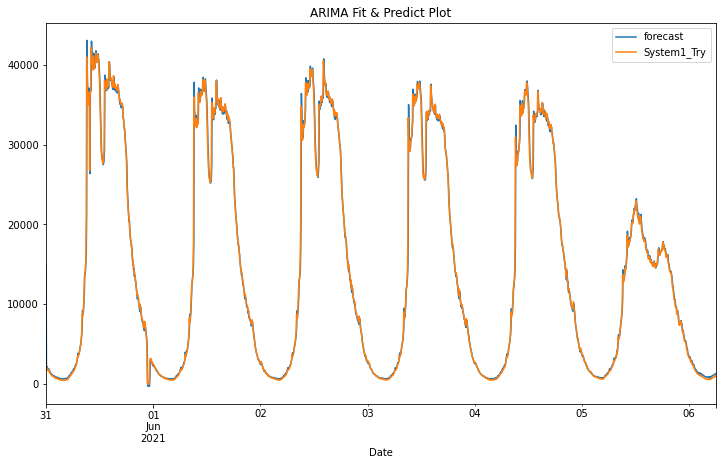

In [31]:
plt.rcParams['figure.figsize'] = (12, 7)
arima.plot_predict()
plt.title('ARIMA Fit & Predict Plot')
plt.show()

실제로 모형이 어떻게 학습 및 예측을 하는지 plot을 그려보았습니다.

평가지표를 활용해 성능을 평가해보겠습니다.

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
print(f"ARIMA 모델의 RMSE : {mean_squared_error(y_test, pred) ** 0.5}")

ARIMA 모델의 RMSE : 11123.322614623636


In [34]:
y_test.max(), y_test.min()

(15664, 1247)

예측 값 정답의 최대가 15664 최소가 1247인 것을 감안하면 RMSE가 11123인 것은 성능이 좋지 않음을 의미합니다.

아무래도 계절성을 반영하지 못한 이유라고 생각합니다.

통계적 시계열 방법에서 중요한 것은 잔차 분석입니다. 먼저 더빈-왓슨 검정으로 잔차의 자기상관성에 대해 알아보겠습니다.

In [63]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(arima.resid)

1.9373091706521532

더빈 왓슨 통계량은 2에 가까울수록 잔차간의 상관성이 없는 것으로 시계열 모델의 적합성을 의미합니다. 통계량의 경우 0에 가까울수록 양의 자기상관이 있으며 4에 가까울수록 음의 자기상관이 존재한다고 판단합니다.

***
ARIMA에 계절성을 추가한 모형인 SARIMA를 활용해 보도록 하겠습니다.

### SARIMAX 모형

#### Seasonal ARIMA 모형은 각 계절에 따른 독립적인 ARIMA 모형이 합쳐져 있는 모형입니다.
#### X는 외부변수를 나타내는 eXogeneous의 줄임말로 자기 자신 뿐만 아니라 외부 변수까지 학습과 예측에 포함할 수 있다는 의미입니다.
#### 기존 ARIMA(p, d, q) 모형에 계절성 주기를 나타내는 차수 s가 추가적으로 필요하여 SARIMA(P, D, Q, s)로 표기합니다.
- s의 값은 월별 계절성의 경우 12이고 분기별 계절성은 4가 됩니다.
- 예를 들어 각 월의 시계열 자료 값이 현재의 백색 잡음 이외에 작년 동월의 백색잡음에 영향을 받는 다면 다음과 같은 단순 SARIMA(0,0,1,12)가 됩니다.

|파라미터 | 설명|
|---|---|
|p| order of non-seasonal AR temrs|
|d|order of non-seasonal differencing|
|q| order of non-seasonal MA terms|
|P| order of seasonal AR terms|
|D| order of seasonal differencing|
|Q|order of seasonal MA terms|
|S| length of the cycle|

#### <center><메서드 주요 파라미터><center>
| 파라미터 | 설명 |
|---|---|
|endog | 관측된 시계열 데이터|
| exog | 관측된 시계열에 영향을 미치는 외부 변수 데이터|
| order | ARIMA의 (p, d, q)|
|seasonal_order | SARIMA의 seasonal component인 (P,D,Q,s)|
|enforce_stationay | AR항이 stationary를 만족하게끔 강제하는 것으로 디폴트는 True|
|enforce_invertibility| MA항이 stationary를 만족하게끔 강제하는 것으로 디폴트는 True|

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

위 메서드는 데이터의 계절성, 트랜드, 잔차를 한번에 plotting 해주는 메서드입니다.

하지만 데이터가 5분 간격으로 계절성을 확인하기에는 간격이 매우 좁아 plot에 오류가 발생하게 됩니다.

더 넓은 범위의 데이터를 확보하게 된다면 아래와 같이 그려질 수 있습니다.

아래 그림은 샘플입니다. 그림처럼 장기간의 데이터인 경우 계절성과 트렌드를 확인할 수 있습니다.

In [36]:
from IPython.display import Image

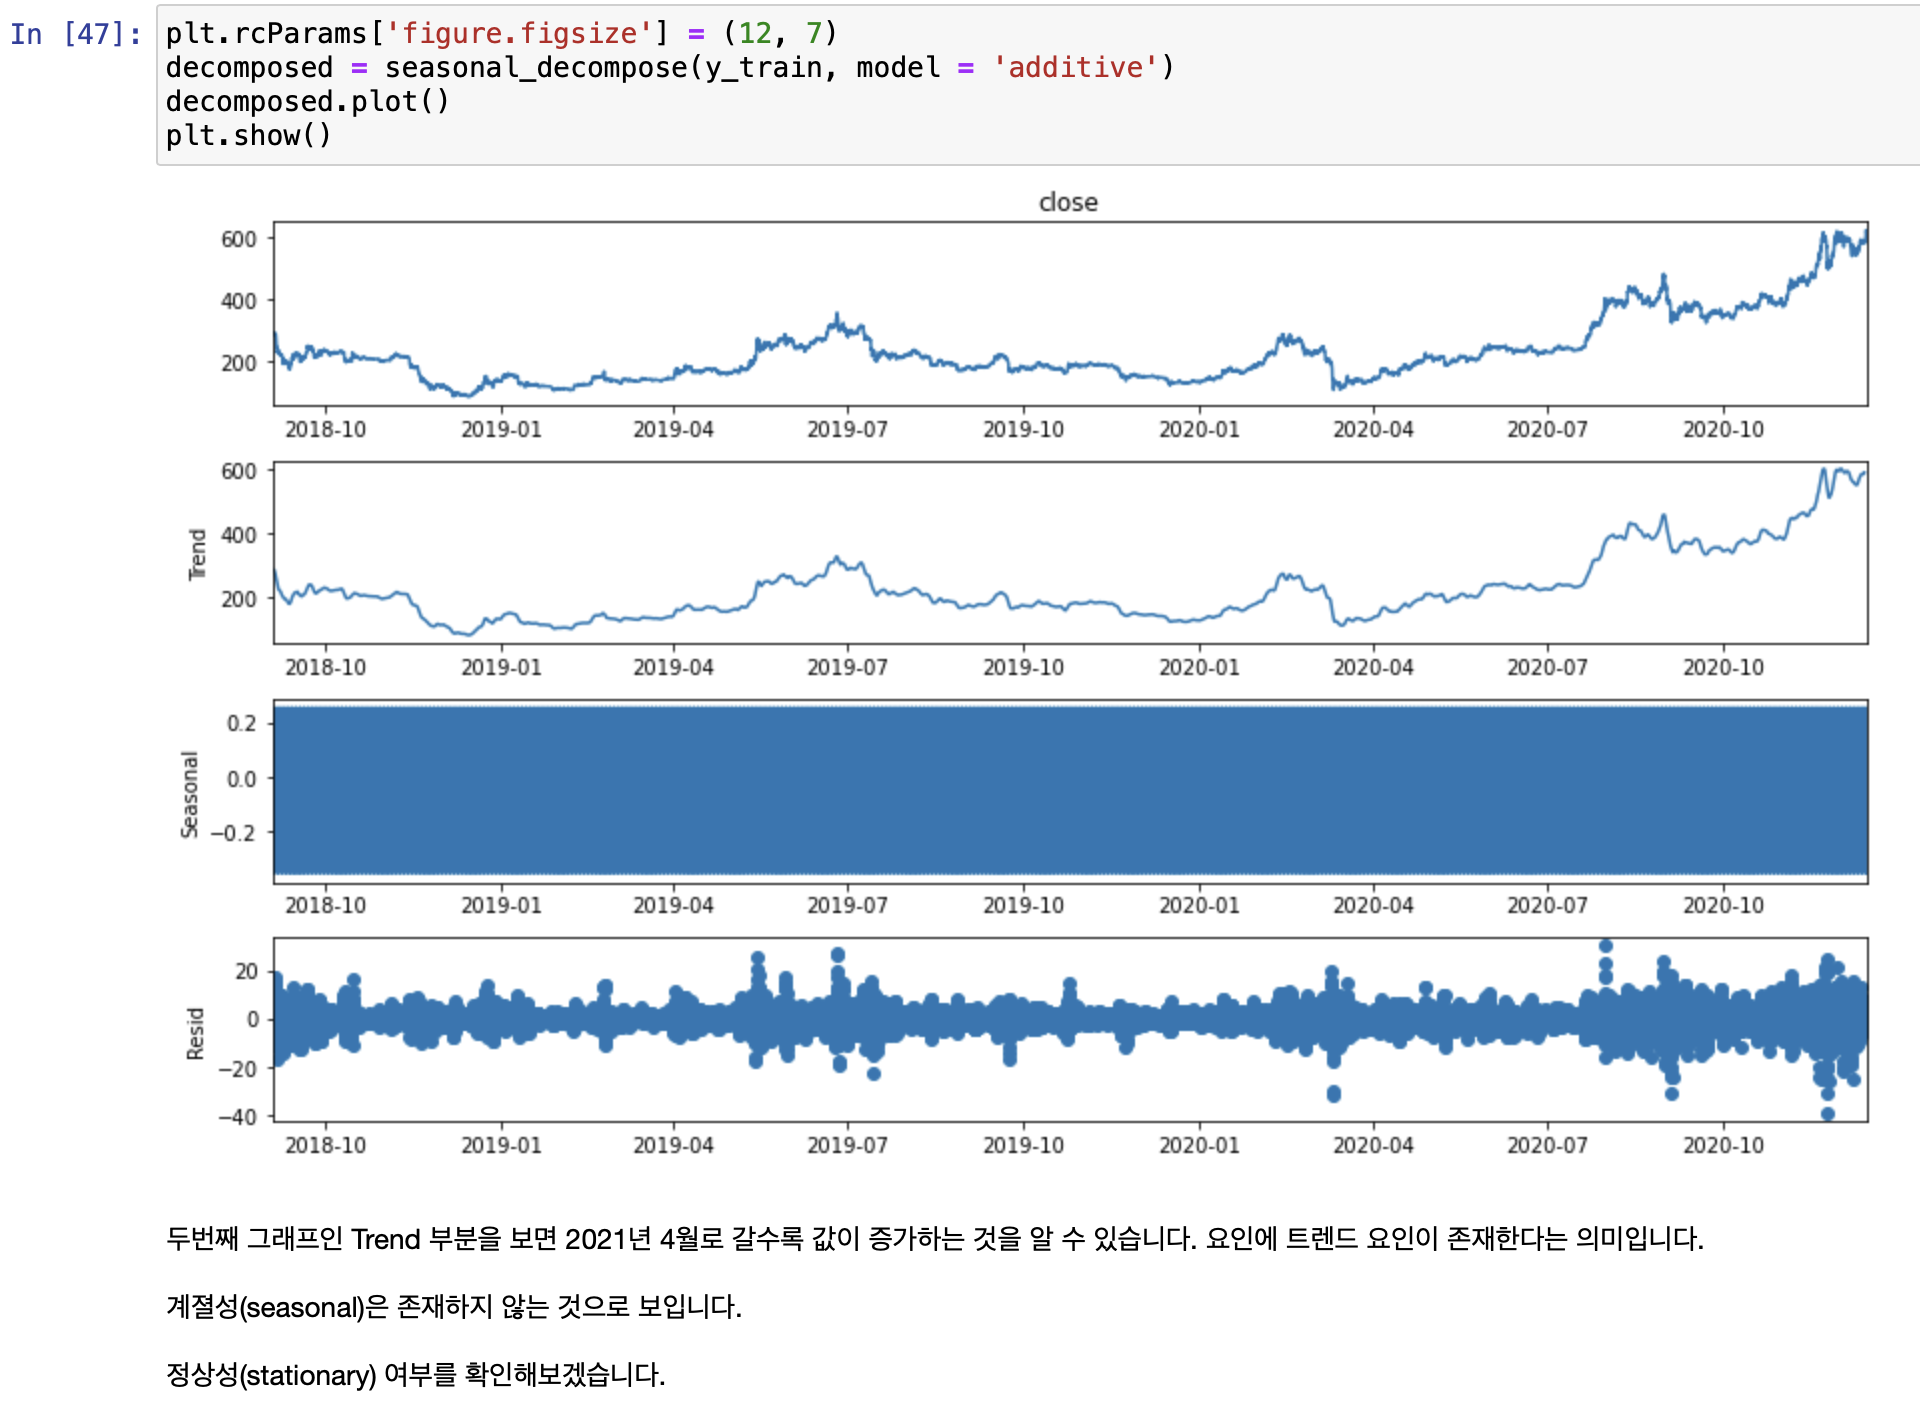

In [37]:
Image('트렌드_계절성.png')

***

SARIMAX 사용을 위해 다른 시간간격의 데이터를 구축해보겠습니다.

첫번째 데이터는 5분 간격의 데이터였고 두번째 데이터는 한 시간 간격의 데이터로 생성해보겠습니다.

In [40]:
data2 = data.resample('H').mean()

In [43]:
data2.head()

,System1_Try,System1_Succ,System2_Try,System2_Succ
Date,,,,
2021-05-31 00:00:00,1741.916667,65.455833,936.500000,68.771667
2021-05-31 01:00:00,1018.583333,64.017500,566.833333,66.660833
2021-05-31 02:00:00,682.916667,64.819167,375.166667,65.956667
2021-05-31 03:00:00,502.416667,64.090000,266.083333,65.756667
2021-05-31 04:00:00,531.750000,63.703333,283.333333,66.223333


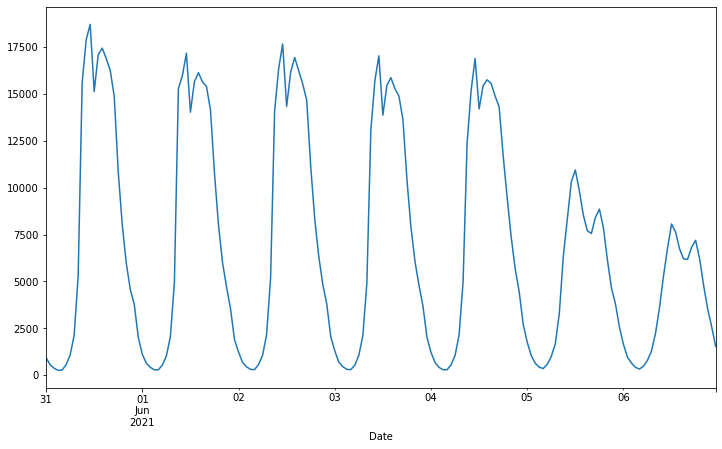

In [45]:
data2.System2_Try.plot()
plt.show()

In [51]:
y_train = data2.System2_Try.iloc[:144]
y_test = data2.System2_Try.iloc[144:]

In [47]:
from itertools import product, combinations
from tqdm import tqdm
from statsmodels.tsa.api import SARIMAX

In [48]:
p, q = range(0,3), range(0,3)
d = range(0, 1)

기존 ARIMA의 파라미터인 p, d, q 값의 범위를 설정합니다.

In [49]:
P, Q = range(0,3), range(0,3)
D = range(0, 2)
S = 24

SARIMAX의 추가된 파라미터인 P, D, Q, S의 범위를 설정합니다.

하루를 주기로 흐름이 나타나므로 24시간 / 1시간인 24을 S로 지정합니다.

In [52]:
trend_pdq = list(product(p, d, q))
seasonal_pdq = [(comb[0], comb[1], comb[2], S) for comb in list(product(P, D, Q))]
## SARIMAX
AIC = []
SARIMAX_order = []
for trend_param in tqdm(trend_pdq):
    for seasonal_params in seasonal_pdq:
        try:
            result = SARIMAX(y_train, trend = 'c', order = trend_param, seasonal_order = seasonal_params,
                             exog = None).fit()
            AIC.append(result.aic)
            SARIMAX_order.append([trend_param, seasonal_params])
        except:
            continue
## Parameter Selection
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_order[AIC.index(min(AIC))][0], SARIMAX_order[AIC.index(min(AIC))][1]))

  0%|          | 0/9 [00:00<?, ?it/s]/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Us

/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 67%|██████▋   | 6/9 [06:08<03:11, 63.93

The smallest AIC is 1922.1269843945006 for model SARIMAX(2, 0, 0)x(2, 1, 2, 24)


In [53]:
model = SARIMAX(y_train, trend = 'c', order = SARIMAX_order[AIC.index(min(AIC))][0], 
                                seasonal_order = SARIMAX_order[AIC.index(min(AIC))][1], exog = None).fit()
display(model.summary())

/Users/kisehyun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                             System2_Try   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(2, 1, [1, 2], 24)   Log Likelihood                -953.063
Date:                                 Sat, 12 Jun 2021   AIC                           1922.127
Time:                                         09:21:37   BIC                           1944.427
Sample:                                     05-31-2021   HQIC                          1931.183
                                          - 06-05-2021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -88.5552    128.833     -0.687      0.492    -341.062     163.952
ar.L1          1.0998      0.070     15.766      0.000       0.963       1.237
ar.L2         -0.2439      0.042     -5.791      0.000      -0.327      -0.161
ar.S.L24       0.8904      0.872      1.022      0.307      -0.818       2.599
ar.S.L48      -0.7767      0.093     -8.390      0.000      -0.958      -0.595
ma.S.L24      -0.9242      0.863     -1.071      0.284      -2.615       0.766
ma.S.L48       0.9891      0.126      7.860      0.000       0.742       1.236
sigma2       4.53e+05      0.002   2.79e+08      0.000    4.53e+05    4.53e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               644.65
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               3.44   Skew:                            -1.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.13e+26. Standard errors may be unstable.
"""

모델을 학습한 후 y_test의 step 만큼 예측을 출력해보겠습니다.


In [54]:
steps = len(y_test)

In [56]:
steps

24

예측하고자 하는 시간은 향후 24시간의 예측 값이며 24로 한 이유는 저희가 실제 24시간의 데이터를 가지고 있기 때문에 성능을 측정하기 위해서 입니다. 24시간 보다 더 이후 값까지 얻고자 하실 때는 24보다 큰 수를 입력하시면 됩니다. 하지만 이럴 경우 데이터가 없어 성능은 알 수 없습니다.

예를 들어 고객님께서는 현재 y_test가 24시간의 데이터만 가지고 계신데 24시간 + 24시간인 48시간의 예측치를 얻으실 경우 48시간 중 이전 24시간에 대한 실제 정답을 가지고 있고 이후 24시간에 대한 정답은 없기 때문에 48시간 예측치에 대한 성능은 아실 수 없습니다!

In [55]:
pred = model.get_forecast(steps).predicted_mean

24시간 예측치를 확보합니다.

In [57]:
print(np.sqrt(mean_squared_error(y_test, pred)))

708.951946066471


RMSE가 708로 값의 범위를 따졌을 때 꽤 괜찮은 결과를 얻었습니다!

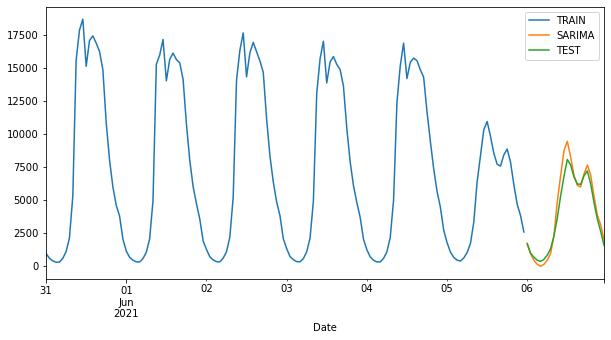

In [60]:
plt.figure(figsize = (10, 5))
ax = y_train.plot(label = 'TRAIN')
pred.plot(label = 'SARIMA')
y_test.plot(label = 'TEST')
plt.legend()
plt.show()

실제 값들과 예측 값의 plot으로 얼마나 잘 예측하였는지 비교해보았습니다.

초록선과 주황선이 상당이 유사한 형태로 그려진 것을 알 수 있습니다.

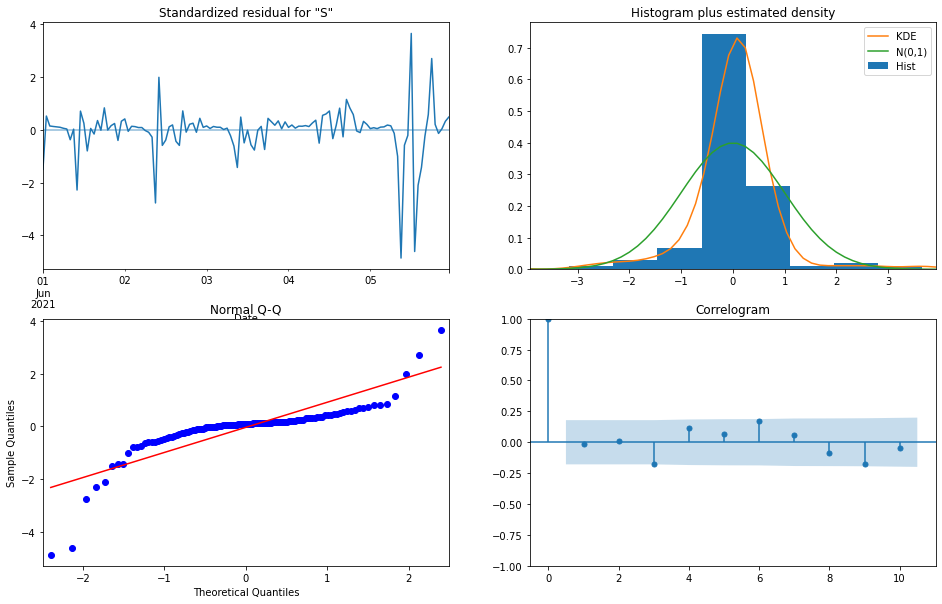

In [64]:
model.plot_diagnostics(figsize = (16,10))
plt.show()

SAIMRAX는 잔차 진단을 한 번에 할 수 있는 plot_diagnostics 메서드를 제공합니다.

좌측 상단 그래프는 표준화 잔차를 나타낸 것으로 기울기가 0인 직선 주변으로 일정한 수준으로 퍼져있을수록 좋은 모델로 평가합니다.

우측 상단 그래프의 주황색 선 잔차의 KDE Plot를 나타낸 것으로 초록색 선인 표준정규분포 선과 유사할수록 정규성을 만족한다고 할 수 있습니다.

좌측 하단 그래프는 Q-Q Plot으로 잔차의 정규성을 의미합니다. 파란색(데이터) 값들이 빨간색 직선위에 위치할수록 정규성을 만족한다고 할 수 있습니다.

우측 하단 그래프는 자기상관성을 그린 그래프로 파란색 박스 안에 모든 점들이 찍혀 자기상관성이 없다고 할 수 있습니다.(0에 위치한 점이 1에 찍힌 것은 맨처음은 자기 자신과 상관관계가 1이기 때문입니다!)

***

지금까지 ARIMA, SARIMA 두 가지 기법을 활용해 시계열 분석의 전체 프로세스를 살펴보았습니다. 기법과 데이터 그리고 전처리 방법에 따라 다양한 결과를 얻으실 수 있습니다. 추가 사항이 있거나 수정 사항이 있으실 경우 말씀해주세요! 이상 OPTIMUM이었습니다. 감사합니다!